In [134]:
import json
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN, GRU, LSTM
from keras.layers.core import Dense, Dropout
from keras.layers.wrappers import TimeDistributed
from keras.layers import Convolution1D, MaxPooling1D
from keras.utils import np_utils
import itertools
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sys, os
import traceback
from itertools import chain
import numpy as np
import pandas as pd

import tensorflow as tf
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def get_sentences(data_list):
    sentences = []
    for a in data_list.article.unique():
        words = []
        prev_n = 0
        for _,s in data_list.loc[data_list.article == a].iterrows():
            n = s['sentence_no']
            if n != prev_n:
                if len(words) > 2 and len(set([x[1] for x in words])) > 1:
                    sentences.append(words)
                words = []
            words.append((s['word'], s['encoding'], s['part_of_speech']))
            prev_n = n
            
        if len(words) > 2 and len(set([x[1] for x in words])) > 1:
            sentences.append(words)
            
    return sentences

In [3]:
data_list = pd.read_csv('../data/go/go_cc3.csv')
data_list.word.fillna('NA', inplace=True)

# temp = pd.read_csv('../data/go_bpmf_2.0_more.csv')
# temp.word.fillna('NA', inplace=True)

# data_list = data_list.merge(temp, on=['article', 'sentence_no', 'word_no'])
# data_list.sort_values(['article', 'sentence_no'], kind='mergesort', inplace=True)
# x_counts = data_list.encoding_x.value_counts()
# y_counts = data_list.encoding_y.value_counts()
# data_list['encoding_x'] = data_list.encoding_x.apply(lambda x: x if x_counts[x] > 4 else 'O')
# data_list['encoding_y'] = data_list.encoding_y.apply(lambda x: x if y_counts[x] > 4 else 'O')
# data_list['encoding'] = [i if i != 'O' else j for i,j in zip(data_list.encoding_x, data_list.encoding_y)]
# data_list = data_list.rename(columns={'word_x' : 'word'})

In [4]:
data_list = get_sentences(data_list)
print(data_list[0])
print(len(data_list))

words = list(set(y[0] for x in data_list for y in x))
n_words = len(words)
print(n_words)

tags = list(set(y[1] for x in data_list for y in x))
n_tags = len(tags)
print(n_tags)

poss = list(set(y[2] for x in data_list for y in x))
n_poss = len(poss)
print(n_poss)

[('CAF-1', 'GO:0033186', 'NNP'), ('Is', 'O', 'VBZ'), ('Essential', 'O', 'NNP'), ('for', 'O', 'IN'), ('Heterochromatin', 'GO:0000792', 'NNP'), ('Organization', 'O', 'NNP'), ('in', 'O', 'IN'), ('Pluripotent', 'O', 'NNP'), ('Embryonic', 'O', 'NNP'), ('Cells', 'O', 'NNP')]
2598
8890
456
43


In [223]:
max_len = 75
max_len_char = 60

word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["O"] = 0
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["O"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

pos2idx = {w: i+1 for i, w in enumerate(poss)}
pos2idx["X"] = 0
idx2pos = {i: w for w, i in pos2idx.items()}

In [224]:
print(tag2idx)

{'3_GO:0097418': 233, '1_GO:0005921': 231, '2_GO:0001739': 232, '2_GO:0008278': 2, '1_GO:0000322': 234, '2_GO:0044317': 235, 'GO:0001917': 3, 'GO:1990742': 6, '4_GO:0005675': 8, '2_GO:0031090': 343, 'GO:0005662': 9, '1_GO:0005576': 236, '2_GO:0060076': 10, '3_GO:0005714': 1, '3_GO:0045178': 239, 'GO:0098794': 305, 'GO:0045177': 238, 'GO:0005712': 13, '2_GO:0005667': 12, 'GO:0000791': 240, '1_GO:0043234': 384, 'GO:0000785': 81, 'GO:0031012': 241, '1_GO:0034399': 242, '2_GO:0097060': 243, '1_GO:0005912': 418, '1_GO:0070161': 5, '2_GO:0001533': 14, '1_GO:0016605': 15, '1_GO:0005635': 4, '2_GO:0045202': 244, 'GO:0005802': 245, '1_GO:0044301': 246, 'GO:0005929': 16, 'GO:0005657': 17, 'GO:0019814': 18, '2_GO:0031941': 19, '3_GO:0043025': 7, '1_GO:0005618': 248, '1_GO:0005615': 249, '2_GO:0005634': 20, '1_GO:0005675': 91, '1_GO:0019867': 21, '2_GO:0017053': 83, '2_GO:0035328': 250, '2_GO:0043235': 267, '1_GO:0035102': 22, '2_GO:0000802': 251, 'GO:0008541': 23, '2_GO:0001741': 24, '2_GO:004517

In [225]:
print(pos2idx)

{'UH': 1, 'FW': 2, 'VBP': 3, "''": 4, 'JJS': 5, '#': 7, 'WDT': 8, 'EX': 9, 'JJ': 10, 'WP$': 13, 'PRP$': 28, 'MD': 14, 'PDT': 15, 'WRB': 16, 'RBS': 17, '``': 18, 'RBR': 6, ',': 19, 'X': 0, '(': 20, 'VBN': 21, 'DT': 23, 'NNP': 12, 'PRP': 26, '.': 25, 'CC': 27, 'RP': 22, 'RB': 29, 'POS': 30, ')': 11, ':': 31, 'VBD': 32, 'VBZ': 33, 'TO': 34, 'JJR': 35, 'WP': 36, 'VB': 37, 'NNPS': 38, 'CD': 39, 'VBG': 40, '$': 41, 'NNS': 42, 'IN': 43, 'NN': 24}


In [226]:
from keras.preprocessing.sequence import pad_sequences
X_word = [[word2idx[w[0]] for w in s] for s in data_list]

In [227]:
X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx["O"], padding='post', truncating='post')

In [228]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)

111


In [229]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["O"] = 0

In [230]:
X_char = []
for sentence in data_list:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("O"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))


In [231]:
X_pos = [[pos2idx[w[2]] for w in s] for s in data_list]
X_pos = pad_sequences(maxlen=max_len, sequences=X_pos, value=pos2idx["X"], padding='post', truncating='post')

In [237]:
def getFeatures(w):
    return [w.istitle(), w.islower(), w.isupper(), w.isdigit(), w.isalpha()]
# X_features = [[getFeatures(w[0]) for w in s] for s in data_list]

X_features = []
for sentence in data_list:
    sent_seq = []
    for i in range(max_len):
        try:
            word_seq = getFeatures(sentence[i][0])
        except:
#             word_seq.append([-1,-1,-1,-1,-1,0])
            word_seq = [0]*5
        sent_seq.append(word_seq)
    X_features.append(np.array(sent_seq))
X_features = np.array(X_features)

In [238]:
y = [[tag2idx[w[1]] for w in s] for s in data_list]
y = pad_sequences(maxlen=max_len, sequences=y,value=tag2idx["O"], padding='post', truncating='post')

In [239]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags+1) for i in y]

In [240]:
from sklearn.model_selection import train_test_split
X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.3, random_state=2018)
X_features_tr, X_features_te, _, _ = train_test_split(X_features, y, test_size=0.3, random_state=2018)
X_pos_tr, X_pos_te, _, _ = train_test_split(X_pos, y, test_size=0.3, random_state=2018)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.3, random_state=2018)

In [248]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D, Flatten
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D
from keras.initializers import RandomUniform

# input and embedding for words
word_in = Input(shape=(max_len,))

emb_word = Embedding(input_dim=n_words + 2, output_dim=len(tag2idx),
                     input_length=max_len, mask_zero=True)(word_in)

# input and embedding for parts of speech
pos_in = Input(shape=(max_len,))
emb_pos = Embedding(input_dim=n_poss + 1, output_dim=len(pos2idx),
                     input_length=max_len, mask_zero=True)(pos_in)

# input and embedding for word features
features_in = Input(shape=(max_len, 5,))
emb_features = TimeDistributed(Embedding(input_dim=2, output_dim=100,
                     input_length=5))(features_in)
features_enc = TimeDistributed(GRU(units=150, return_sequences=False,
                                recurrent_dropout=0.5))(emb_features)

# input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=100,
                           input_length=max_len_char))(char_in)

dropout = Dropout(0.3)(emb_char)

# CNN
conv1d_out = TimeDistributed(Conv1D(kernel_size=3, filters=30, padding='same', activation='tanh', strides=1), name="Convolution")(dropout)
maxpool_out = TimeDistributed(MaxPooling1D(max_len_char), name="Maxpool")(conv1d_out)
char = TimeDistributed(Flatten(), name="Flatten")(maxpool_out)
char = Dropout(0.3)(char)
# character GRU to get word encodings by characters
# char_enc = TimeDistributed(GRU(units=150, return_sequences=False,
#                                 recurrent_dropout=0.5))(emb_char)

# main GRU
x = concatenate([emb_word, features_enc, emb_pos, char])

output = Bidirectional(GRU(200, 
                                    return_sequences=True, 
                                    dropout=0.5,                        # on input to each LSTM block
                                    recurrent_dropout=0.25     # on recurrent input signal
                                   ), name="BLSTM")(x)
output = TimeDistributed(Dense(n_tags + 1, activation='sigmoid'),name="Softmax_layer")(output)

model = Model([word_in, features_in, pos_in, char_in], output)

In [304]:
from keras.optimizers import RMSprop,SGD,Adam

rmsopt = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model.compile(optimizer=rmsopt, loss="categorical_crossentropy", metrics=["acc"])

In [305]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_79 (InputLayer)           (None, 75, 60)       0                                            
__________________________________________________________________________________________________
time_distributed_46 (TimeDistri (None, 75, 60, 100)  11300       input_79[0][0]                   
__________________________________________________________________________________________________
dropout_40 (Dropout)            (None, 75, 60, 100)  0           time_distributed_46[0][0]        
__________________________________________________________________________________________________
Convolution (TimeDistributed)   (None, 75, 60, 30)   9030        dropout_40[0][0]                 
__________________________________________________________________________________________________
input_78 (

In [306]:
from keras.utils import plot_model
plot_model(model, to_file='../data/output/graphs/GRU-CharCNN.png')

In [319]:
# history = model.fit([X_word_tr,
#                      np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
#                     np.array(y_tr).reshape(len(y_tr), max_len, 1),
#                     batch_size=32, epochs=15, validation_data=([X_word_te,
#                      np.array(X_char_te).reshape((len(X_char_te), max_len, max_len_char))],
#                     np.array(y_te).reshape(len(y_te), max_len, 1)),
#                     verbose=1)
history = model.fit([X_word_tr, X_features_tr, X_pos_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    np.array(y_tr),
                    batch_size=32, epochs=15, validation_data=([X_word_te, X_features_te, X_pos_te,
                     np.array(X_char_te).reshape((len(X_char_te), max_len, max_len_char))],
                    np.array(y_te)),
                    verbose=1)

Train on 1818 samples, validate on 780 samples
Epoch 1/50
1818/1818 [==============================] - 25s 14ms/step - loss: 8.9097e-04 - acc: 0.9999 - val_loss: 0.1233 - val_acc: 0.9836
Epoch 2/50
1818/1818 [==============================] - 25s 14ms/step - loss: 8.8259e-04 - acc: 0.9999 - val_loss: 0.1232 - val_acc: 0.9836
Epoch 3/50
1818/1818 [==============================] - 25s 14ms/step - loss: 8.5781e-04 - acc: 1.0000 - val_loss: 0.1232 - val_acc: 0.9836
Epoch 4/50
1818/1818 [==============================] - 24s 13ms/step - loss: 9.0393e-04 - acc: 1.0000 - val_loss: 0.1232 - val_acc: 0.9836
Epoch 5/50
1818/1818 [==============================] - 25s 14ms/step - loss: 8.7455e-04 - acc: 1.0000 - val_loss: 0.1231 - val_acc: 0.9836
Epoch 6/50
1818/1818 [==============================] - 25s 14ms/step - loss: 9.1511e-04 - acc: 0.9999 - val_loss: 0.1231 - val_acc: 0.9836
Epoch 7/50
1818/1818 [==============================] - 25s 13ms/step - loss: 9.0014e-04 - acc: 1.0000 - val_loss

In [320]:
hist = pd.DataFrame(history.history)
hist.to_csv('../data/results/performance/GO_GRU-CharCNN.tsv', sep='\t')

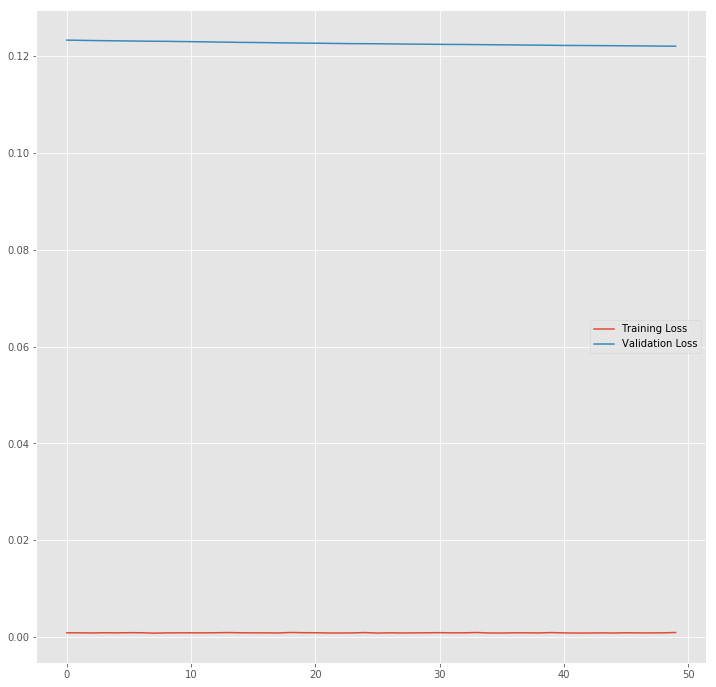

In [321]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["loss"], label='Training Loss')
plt.plot(hist["val_loss"], label='Validation Loss')
plt.legend()
plt.show()

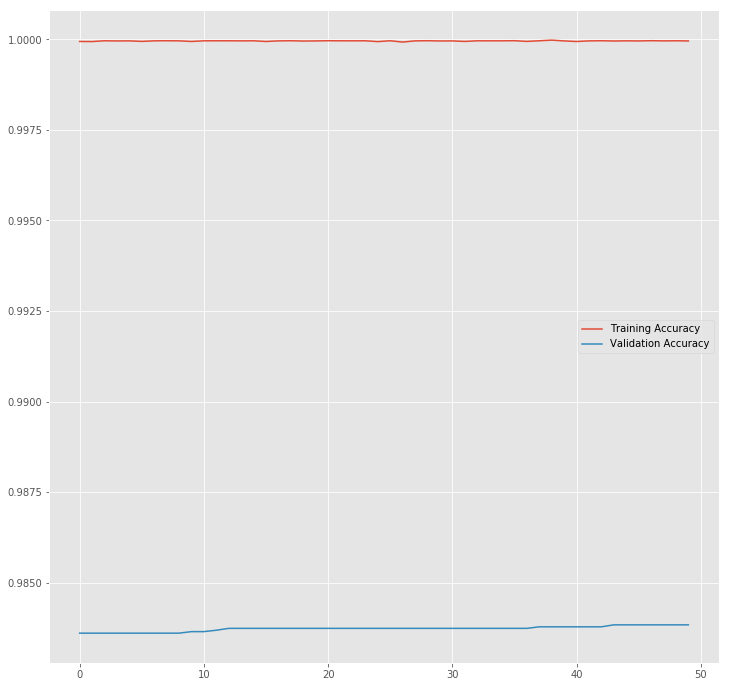

In [322]:
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["acc"], label='Training Accuracy')
plt.plot(hist["val_acc"], label='Validation Accuracy')
plt.legend()
plt.show()

In [323]:
from sklearn.metrics import classification_report

predicted = model.predict([X_word_te, X_features_te, X_pos_te,
                        np.array(X_char_te).reshape((len(X_char_te),
                                                     max_len, max_len_char))])
true = []
predicted_val = []
word = []
for i in range(len(predicted)):
    p_tmp = np.argmax(predicted[i], axis=-1)
    t_tmp = np.argmax(y_te[i], -1)
    word.append(X_word_te[i])
    predicted_val.append(p_tmp)
    true.append(t_tmp)

wd = [list(map(lambda x: idx2word[x], y)) for y in word]    
p = [list(map(lambda x: idx2tag[x], y)) for y in predicted_val]
t = [list(map(lambda x: idx2tag[x], y)) for y in true]

report = classification_report(list(itertools.chain.from_iterable(t)), 
                                    list(itertools.chain.from_iterable(p)))
# print "\n"
print(report)

              precision    recall  f1-score   support

1_GO:0000322       0.00      0.00      0.00         0
1_GO:0000790       0.00      0.00      0.00         1
1_GO:0000795       1.00      1.00      1.00         4
1_GO:0000800       1.00      1.00      1.00         1
1_GO:0000803       1.00      1.00      1.00         3
1_GO:0000805       0.89      1.00      0.94         8
1_GO:0000806       1.00      1.00      1.00         2
1_GO:0001739       1.00      1.00      1.00         9
1_GO:0001741       0.85      1.00      0.92        22
1_GO:0001750       0.92      1.00      0.96        24
1_GO:0001917       0.88      1.00      0.93         7
1_GO:0005610       0.00      0.00      0.00         0
1_GO:0005615       0.00      0.00      0.00         1
1_GO:0005634       0.88      0.88      0.88         8
1_GO:0005640       0.00      0.00      0.00         0
1_GO:0005643       0.00      0.00      0.00         1
1_GO:0005657       0.50      0.50      0.50         2
1_GO:0005667       0.00    

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [324]:
# report_lines = report.splitlines()[2:]
# labels = []
# precision = []
# recall = []
# f1 = []
# support = []
# for line in report_lines:
#     data = line.split()
#     labels.append(data[0])
#     precision.append(float(data[1]))
#     recall.append(float(data[2]))
#     f1.append(float(data[3]))
#     support.append(float(data[4]))
#     if(data[0] == 'O'):
#         break

In [325]:
# precision_all_but_O = sum((np.array(precision[:-1]) * np.array(support[:-1])))/sum(support)
# recall_all_but_O = sum((np.array(recall[:-1]) * np.array(support[:-1])))/sum(support)
# f1_all_but_O = sum((np.array(f1[:-1]) * np.array(support[:-1])))/sum(support)

In [326]:
# print(precision_all_but_O)
# print(recall_all_but_O)
# print(f1_all_but_O)

In [327]:
i = 300
pred = np.argmax(predicted[i], axis=-1)
print(pred)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, tr, pred in zip(X_word_te[i], np.argmax(y_te[i], -1), pred):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w], idx2tag[tr], idx2tag[pred]))
        
# pd = model.predict(np.array([X_te[i]]))
# pd = np.argmax(pd, axis=-1)
# true = np.argmax(y_te[i], -1)
# print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
# print(30 * "=")

# for w, t1, pred in zip(X_te[i], true, pd[0]):
#     if w != 0:
#         print("{:15}: {:5} {}".format(words[w-1], tags[t1], tags[pred]))

[  0   0   0   0   0 200   0   0   0   0   0   0   0   0 143   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0 272   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]
Word           ||True ||Pred
persisted      : O     O
4A             : O     O
Buffer         : O     O
Kidney         : O     O
K14-driven     : O     O
transporter    : GO:0005634 GO:0005634
dimethylation  : O     O
permit         : O     O
anti-rat       : O     O
Diminished     : O     O
rather         : O     O
H2A            : O     O
K14-driven     : O     O
Buffer         : O     O
unwinds        : O     GO:0005576
acids          : O     O
pre-incubated  : O     O
unlike         : O     O
pre-incubated  : O     O
possible       : O     O
knock-in       : O     O
insulin-like   : O     O
anti-rat       : O     O
dying          : O     O
share          : O     O
founder        : 

In [328]:
import pandas as pd

df = pd.DataFrame(
{
    'Predicted' : list(itertools.chain.from_iterable(p)),
    'Ground Truth': list(itertools.chain.from_iterable(t)),
    'Word' : list(itertools.chain.from_iterable(wd)),
}
)


In [329]:
df = df[df['Word'] != 'O']

In [330]:
df1 = df[(df['Predicted'] != 'O') & (df['Ground Truth'] != 'O') | 
         (df['Predicted'] == 'O') & (df['Ground Truth'] != 'O') |
         (df['Predicted'] != 'O') & (df['Ground Truth'] == 'O')
        ]

report = classification_report(df1['Ground Truth'], 
                                    df1['Predicted'])
print("\n")
print(report)



              precision    recall  f1-score   support

1_GO:0000322       0.00      0.00      0.00         0
1_GO:0000790       0.00      0.00      0.00         1
1_GO:0000795       1.00      1.00      1.00         4
1_GO:0000800       1.00      1.00      1.00         1
1_GO:0000803       1.00      1.00      1.00         3
1_GO:0000805       0.89      1.00      0.94         8
1_GO:0000806       1.00      1.00      1.00         2
1_GO:0001739       1.00      1.00      1.00         9
1_GO:0001741       0.85      1.00      0.92        22
1_GO:0001750       0.92      1.00      0.96        24
1_GO:0001917       0.88      1.00      0.93         7
1_GO:0005610       0.00      0.00      0.00         0
1_GO:0005615       0.00      0.00      0.00         1
1_GO:0005634       0.88      0.88      0.88         8
1_GO:0005640       0.00      0.00      0.00         0
1_GO:0005643       0.00      0.00      0.00         1
1_GO:0005657       0.50      0.50      0.50         2
1_GO:0005667       0.00  

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [303]:
# df.to_csv('../data/results/GO_merged_CHAR_LSTM_Based_CRF.tsv', sep='\t')

In [271]:
# !python ./Go_Deep/src/accuracy/src/computeSim.py ../data/results/GO_merged_CHAR_LSTM_Based_CRF.tsv ../data/validation_data/GO_AllSubsumers.tsv 
#%run ./Go_Deep/src/accuracy/src/computeSim.py ../data/results/GO_merged_CHAR_LSTM_Based_CRF.tsv ../data/validation_data/GO_AllSubsumers.tsv 